# Daily mean pre-processor notebook

##### Authors : Will Wieder wwieder@ucar.edu [@wwieder](https://github.com/wwieder), modified from work by Negin Sobhani negins@ucar.edu [@negin513](https://github.com/negin513), 

##### Last revised: 2023-01-22
_______

This is a notebook for reading NEON simulation and evaluation files and save them as csv files. 

In [5]:
import os
import time
import datetime

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import xarray as xr

from glob import glob
from os.path import join

import tqdm
import cftime

In [6]:
print('xarray '+xr.__version__) ##-- was working with 0.20.0

xarray 2022.6.0


## Dask Cluster
The following will spin up a dask cluster,  only works on NCAR machines. 
16 workers worked best for NEON.

In [7]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(16)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38127 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/38127/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/38127/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:39602,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/38127/status,Total threads: 0
Started: Just now,Total memory: 0 B


---------------------------

In [4]:
# -- read list of sites:
#neon_sites_pft = pd.read_csv('/glade/scratch/negins/preprocessed_neon_csv_data/neon_sites_dompft.csv')
neon_sites_pft = pd.read_csv('/glade/scratch/wwieder/run_NEON_v2/tools/site_and_regional/neon_sites_dompft.csv')
neon_sites = neon_sites_pft['Site'].to_list()

# Short list for testing:
neon_sites = ['KONZ']

failed_sites = [] # -- list for saving failed sites

### Download evaluation data
This is slow and only has to be done once!

In [5]:
# -- read only these variables from the whole netcdf files

def preprocess (ds):
    '''
    reading ALL variables from ctsm outputs
    '''
    variables = ['AR','ELAI','FCEV','FCTR','FGEV','FIRA','FSA',
                 'FSDSNDLN','FSDSNI','FSDSVDLN','FSDSVI','FSH',
                 'FSRNDLN','FSRNI','FSRVDLN','FSRVI','GPP','H2OSOI',
                 'HR','RAIN','SNOW','SNOW_DEPTH','SOILPSI','TBOT','TSOI']

    ds_new= ds[variables]
    # select 3rd soil layer (for now)
    ds_new['TSOI'] = ds_new['TSOI'].isel(levgrnd=2)
    ds_new['SOILPSI'] = ds_new['SOILPSI'].isel(levgrnd=2)
    ds_new['H2OSOI'] = ds_new['H2OSOI'].isel(levsoi=2)
    return ds_new

In [6]:
ds_ctsm

NameError: name 'ds_ctsm' is not defined

In [7]:
# -- fix timestamp on CTSM files so they can be matched with eval files

def fix_time (ds):
    '''
    fix time formatting with reading multiple cesm files.
    '''
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    month0 = ds['time.month'][0].values
    day0 = ds['time.day'][0].values

    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='30min')
    ds['time']= ds['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
    return ds

In [8]:
#-- path to save the csv files:
csv_dir = "/glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/"

#create the directory if it does not exist:
if not os.path.isdir(csv_dir):
    os.mkdir(csv_dir)

In [9]:
years = ["2018","2019","2020","2021"]

for neon_site in neon_sites:
    try: 

        start_site = time.time()

        print ('---------------------------')
        print ("Extracting data for "+neon_site)
        sim_files =[]
        for year in years:
            sim_path = "/glade/scratch/wwieder/run_NEON_v2/tools/site_and_regional/archive/"+neon_site+".transient/lnd/hist/"
            sim_files.extend(sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc"))))

        print("All simulation files for all years: [", len(sim_files), "files]")

        start = time.time()

        ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, 
                                    combine='by_coords',parallel=True,
                                    preprocess=preprocess).load()
        ds_ctsm = fix_time (ds_ctsm)

        end = time.time()
        print("Reading all simulation files took:", end-start, "s.")

        eval_files = []
        for year in years:
            eval_dir = "/glade/work/wwieder/neon/eval_files/"+neon_site
            eval_files.extend(sorted(glob(join(eval_dir,neon_site+"_eval_"+year+"*.nc"))))


        print ("All evaluation files for all years: [", len(eval_files), "files]")

        start = time.time()

        ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords').load()

        end = time.time()
        print("Reading all observation files took:", end-start, "s.")
        
        #Convert CTSM data to a Pandas Dataframe for easier handling:
        #ctsm_vars = ['FCEV', 'FCTR', 'FGEV','FSH','GPP','FSA','FIRA','AR','HR','ELAI','RAIN','SNOW']
        ctsm_vars = list(ds_ctsm.var())

        df_ctsm = pd.DataFrame({'time':ds_ctsm.time})
        df_ctsm['time'] = pd.to_datetime(df_ctsm['time'],format= '%Y-%m-%d %H:%M:%S' )

        for var in tqdm.tqdm(ctsm_vars):
            sim_var_name = "sim_"+var
            field = np.ravel ( ds_ctsm[var])     
            df_ctsm[sim_var_name]=field
            #-- shift simulation data by one time step
            df_ctsm[sim_var_name]=df_ctsm[sim_var_name].shift(-1).values


        #Convert NEON data to a Pandas Dataframe for easier handling:
        eval_vars = ['NEE','FSH','EFLX_LH_TOT','GPP','Rnet']

        df_all = pd.DataFrame({'time':ds_eval.time})

        for var in eval_vars:
            field = np.ravel (ds_eval[var])
            df_all[var]=field
        
        # -- merge two pandas dataframe on time
        df_all=df_all.merge(df_ctsm.set_index('time'), on='time', how='left')

        clm_var = 'sim_EFLX_LH_TOT'
        # -- Latent Heat Flux:
        # -- EFLX_LH_TOT = FCEV + FCTR +FGEV
        df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

        clm_var = 'sim_Rnet'
        # -- Net Radiation:
        # -- Rnet = FSA-FIRA
        df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

        clm_var = 'sim_NEE'
        # -- Net Ecosystem Exchange
        # -- NEE = GPP- (AR+HR)
        # -- It seems like the sign are opposite so we calculated negative NEE
        df_all [clm_var] = -(df_all ['sim_GPP']-(df_all['sim_AR']+df_all['sim_HR']))

        # convert NEE units from  umolm-2s-1 to gc/m2/s
        df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
        df_all ['GPP']= df_all ['GPP']*(12.01/1000000)

        # -- convert gc/m2/s to gc/m2/day
        df_all ['NEE']= df_all['NEE']*60*60*24
        df_all ['sim_NEE']= df_all['sim_NEE']*60*60*24

        df_all ['GPP']= df_all['GPP']*60*60*24
        df_all ['sim_GPP']= df_all['sim_GPP']*60*60*24

        #-- extract year, month, day, hour information from time
        df_all['year'] = df_all['time'].dt.year
        df_all['month'] = df_all['time'].dt.month
        df_all['day'] = df_all['time'].dt.day
        df_all['hour'] = df_all['time'].dt.hour

        tzone_shift = ds_eval.TimeDiffUtcLt

        #convert to local time
        df_all['local_time']= df_all['time'] + datetime.timedelta(hours=int(tzone_shift))
        df_all['local_hour'] = df_all['local_time'].dt.hour
        df_all['site']=neon_site

        # Write out 30 minute data
        #csv_out = join(csv_dir, "preprocessed_"+neon_site+".csv")
        #df_all.to_csv(csv_out,index=False)

        #calculate daily means
        df_all['local_date'] = df_all['local_time'].astype('M8[D]')
        df_day = df_all.groupby(df_all['local_date']).mean()
        #mask out days with missing values
        df_count = df_all.groupby(df_all['local_date']).count()
        df_day = df_day.where(df_count==48)
        
        # Write out daily minute data
        csv_out = join(csv_dir, "mean_daily_"+neon_site+".csv")
        df_day.to_csv(csv_out,index=True)

        
        end_site = time.time()
        print ("Extracting data for "+neon_site+" took : ", end_site-start_site, "s.")
        print ("Preprocessed file is saved as : ", csv_out)

    except Exception as e: 
        print (e)
        print ('THIS SITE FAILED:', neon_site)
        failed_sites.append(neon_site)
        pass

---------------------------
Extracting data for KONZ
All simulation files for all years: [ 1461 files]
Reading all simulation files took: 105.97584986686707 s.
All evaluation files for all years: [ 48 files]
Reading all observation files took: 4.1518449783325195 s.


100%|██████████| 25/25 [00:00<00:00, 1533.61it/s]

Extracting data for KONZ took :  110.38595151901245 s.
Preprocessed file is saved as :  /glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/mean_daily_KONZ.csv


In [10]:
print ("Extracting data for ", len(failed_sites), "sites failed : ")
print (*failed_sites, sep=" \n")

Extracting data for  0 sites failed : 



In [11]:
list(ds_ctsm.var())

['AR',
 'ELAI',
 'FCEV',
 'FCTR',
 'FGEV',
 'FIRA',
 'FSA',
 'FSDSNDLN',
 'FSDSNI',
 'FSDSVDLN',
 'FSDSVI',
 'FSH',
 'FSRNDLN',
 'FSRNI',
 'FSRVDLN',
 'FSRVI',
 'GPP',
 'H2OSOI',
 'HR',
 'RAIN',
 'SNOW',
 'SNOW_DEPTH',
 'SOILPSI',
 'TBOT',
 'TSOI']

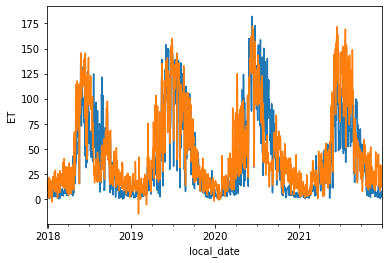

In [37]:
df_day.EFLX_LH_TOT.plot()
df_day.sim_EFLX_LH_TOT.plot() ;
plt.ylabel('ET');


<AxesSubplot:xlabel='local_date', ylabel='LAI & Matric Potential'>

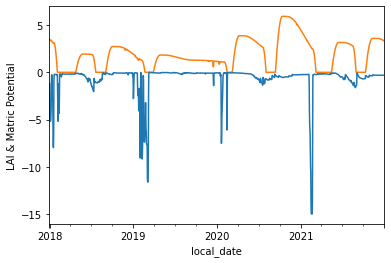

In [42]:
df_day.sim_ELAI.plot(color='tab:orange')
plt.ylabel('LAI & Matric Potential');
df_day.sim_SOILPSI.plot(color='tab:blue')


In [40]:
df_day.var()

NEE                3.316937e+00
FSH                5.521310e+02
EFLX_LH_TOT        1.713359e+03
GPP                1.182677e+01
Rnet               4.270678e+03
sim_AR             6.661103e-10
sim_ELAI           2.454198e+00
sim_FCEV           1.313907e+02
sim_FCTR           9.366448e+02
sim_FGEV           1.362618e+02
sim_FIRA           1.010489e+03
sim_FSA            6.908995e+03
sim_FSDSNDLN                NaN
sim_FSDSNI         2.101265e+01
sim_FSDSVDLN                NaN
sim_FSDSVI         8.885757e+01
sim_FSH            1.002185e+03
sim_FSRNDLN                 NaN
sim_FSRNI          2.592855e+00
sim_FSRVDLN                 NaN
sim_FSRVI          2.805838e+00
sim_GPP            1.708462e+01
sim_H2OSOI         4.270080e-03
sim_HR             6.206097e-11
sim_RAIN           2.037639e-09
sim_SNOW           5.000726e-11
sim_SNOW_DEPTH     2.361955e-03
sim_SOILPSI        2.871145e+00
sim_TBOT           1.187499e+02
sim_TSOI           1.122380e+02
sim_EFLX_LH_TOT    1.757466e+03
sim_Rnet

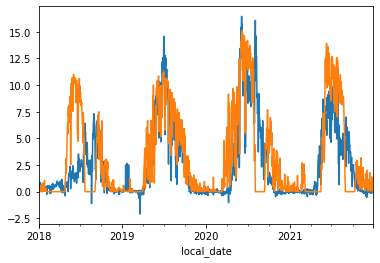

In [28]:
df_day.GPP.plot();
df_day.sim_GPP.plot();

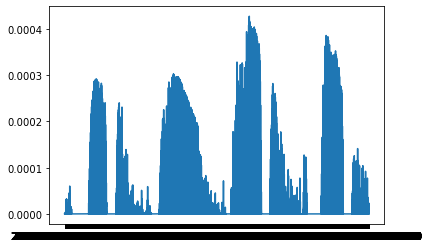

In [30]:
#ds_ctsm.FSDSNDLN.isel(lndgrid=0).plot() ;
plt.plot(ds_ctsm.time, ds_ctsm.GPP.isel(lndgrid=0)) ;